In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

## Gathering Data

In [3]:
image_dir = 'C:/Users/kokum/Downloads/Data set/May12_2030(Both)/IMG'
driving_log_path = 'C:/Users/kokum/Downloads/Data set/May12_2030(Both)/driving_log.csv'

df = pd.read_csv(driving_log_path, header=None)
df.columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

df = shuffle(df)

## Data Preprocessing 

### Image Loading
- removing whitespaces in the image path
- Converting to RGB

In [4]:
def load_image(image_path):
    image = cv2.imread(image_path.strip())
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

### Cropping
cropping off unneccary parts of the image
- 60 pixels from top to remove the sky
- 25 pixels from bottom to remove the hood 

In [5]:
def crop(image):
    return image[60:-25, :, :]

### Resizing
Resizing image to 200*66 through interpolation

In [6]:
def resize(image):
    return cv2.resize(image, (200, 66))

### Normalizing
Convert pixel values from 0-255 to (-1)-1

In [7]:
def normalize(image):
    return image / 127.5 - 1.0

### Random Flipping
randomly mirroring images wih the streeing angle to increase the symmetric behaviour of the data

In [8]:
def random_flip(image, steering):
    if np.random.rand() < 0.5:
        return cv2.flip(image, 1), -steering
    return image, steering

### Running the Data Augmentation

In [9]:
def preprocess_and_augment(image_path, steering_angle):
    image = load_image(os.path.join(image_dir, os.path.basename(image_path)))
    image = crop(image)
    image = resize(image)
    image, steering_angle = random_flip(image, steering_angle)
    image = normalize(image)
    return image, steering_angle

### Viewing Augmented Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9921568627450981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9921568627450981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9686274509803922..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843137254902..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9921568627450981].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..

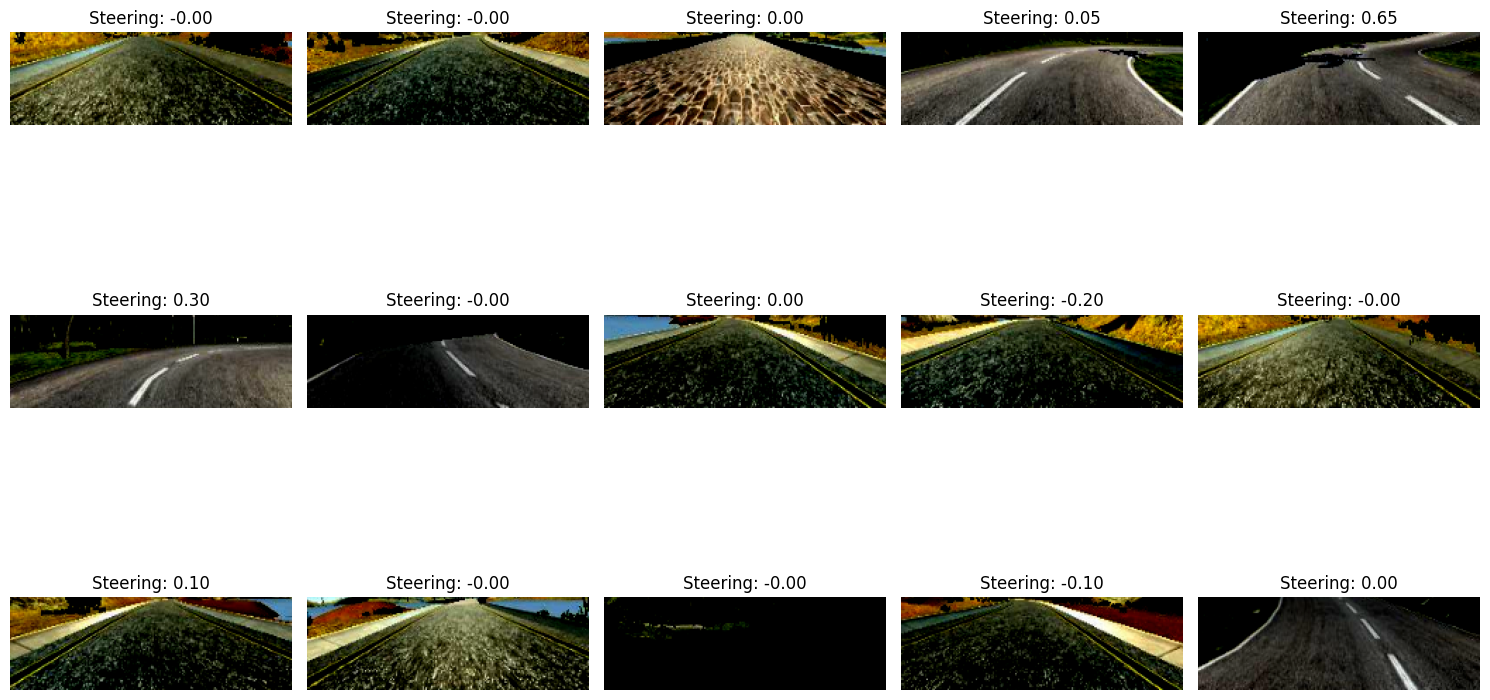

In [9]:
import matplotlib.pyplot as plt

num_samples = 15

plt.figure(figsize=(15, 10))

for i in range(num_samples):
    # Get file path and steering angle from CSV
    image_path = df.iloc[i]['center']
    angle = df.iloc[i]['steering']
    
    # Apply full preprocessing + augmentation pipeline
    image, adjusted_angle = preprocess_and_augment(image_path, angle)

    # Plot it
    plt.subplot(3, 5, i+1)
    plt.imshow(image)
    plt.title(f"Steering: {adjusted_angle:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [10]:
def data_generator(dataframe, batch_size=32):

    num_samples = len(dataframe)

    while True:  # Loop forever (required for Keras .fit)
        dataframe = shuffle(dataframe)

        for offset in range(0, num_samples, batch_size):
            batch_df = dataframe.iloc[offset:offset + batch_size]

            images = []
            angles = []

            for _, row in batch_df.iterrows():
                img_path = row['center']  # <-- This must match the column name in your CSV
                angle = row['steering']   # <-- Same here
                image, angle = preprocess_and_augment(img_path, angle)
                images.append(image)
                angles.append(angle)

            yield np.array(images), np.array(angles)




In [11]:
df = shuffle(df)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


Model

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel1(nn.Module):
    def __init__(self):
        super(CNNModel1, self).__init__()
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 24, kernel_size=5, stride=2),  # Output: (24, 31, 98)
            nn.BatchNorm2d(24),
            nn.ReLU(),

            nn.Conv2d(24, 36, kernel_size=5, stride=2), # (36, 14, 47)
            nn.BatchNorm2d(36),
            nn.ReLU(),

            nn.Conv2d(36, 48, kernel_size=5, stride=2), # (48, 5, 22)
            nn.BatchNorm2d(48),
            nn.ReLU(),

            nn.Conv2d(48, 64, kernel_size=3),           # (64, 3, 20)
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3),           # (64, 1, 18)
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 1 * 18, 100),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(50, 10),
            nn.ReLU(),

            nn.Linear(10, 1)  # Output: single steering angle
        )
    
    def forward(self, x):
        x = self.conv_block(x)
        x = self.fc_block(x)
        return x


Code to save model after each epoch

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Assuming CNNModel1, data_generator, train_df, val_df, and device are already defined

# Step 1: Instantiate model and move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel1().to(device)

# Step 2: Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Step 3: Set batch size and create generators
batch_size = 32
train_gen = data_generator(train_df, batch_size=batch_size)
val_gen = data_generator(val_df, batch_size=batch_size)

# Step 4: Training loop
epochs = 30
steps_per_epoch = len(train_df) // batch_size
val_steps = len(val_df) // batch_size

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for step in range(steps_per_epoch):
        images, angles = next(train_gen)

        # Transpose images to NCHW format for PyTorch
        images = np.transpose(images, (0, 3, 1, 2))
        images = torch.tensor(images, dtype=torch.float32).to(device)
        angles = torch.tensor(angles, dtype=torch.float32).unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, angles)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / steps_per_epoch

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for _ in range(val_steps):
            val_images, val_angles = next(val_gen)

            # Transpose images to NCHW format for PyTorch
            val_images = np.transpose(val_images, (0, 3, 1, 2))
            val_images = torch.tensor(val_images, dtype=torch.float32).to(device)
            val_angles = torch.tensor(val_angles, dtype=torch.float32).unsqueeze(1).to(device)

            val_outputs = model(val_images)
            val_loss += criterion(val_outputs, val_angles).item()

    avg_val_loss = val_loss / val_steps

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    # Save the model after each epoch
    model_filename = f'Model1Run3_epoch{epoch+1}.pth'
    torch.save(model.state_dict(), model_filename)
    print(f"Saved model to {model_filename}")


Epoch 1/30 - Train Loss: 0.0581 - Val Loss: 0.0492
Saved model to Model1Run3_epoch1.pth
Epoch 2/30 - Train Loss: 0.0498 - Val Loss: 0.0494
Saved model to Model1Run3_epoch2.pth
Epoch 3/30 - Train Loss: 0.0479 - Val Loss: 0.0462
Saved model to Model1Run3_epoch3.pth
Epoch 4/30 - Train Loss: 0.0467 - Val Loss: 0.0455
Saved model to Model1Run3_epoch4.pth
Epoch 5/30 - Train Loss: 0.0456 - Val Loss: 0.0449
Saved model to Model1Run3_epoch5.pth
Epoch 6/30 - Train Loss: 0.0450 - Val Loss: 0.0446
Saved model to Model1Run3_epoch6.pth
Epoch 7/30 - Train Loss: 0.0445 - Val Loss: 0.0450
Saved model to Model1Run3_epoch7.pth
Epoch 8/30 - Train Loss: 0.0441 - Val Loss: 0.0444
Saved model to Model1Run3_epoch8.pth
Epoch 9/30 - Train Loss: 0.0435 - Val Loss: 0.0453
Saved model to Model1Run3_epoch9.pth
Epoch 10/30 - Train Loss: 0.0431 - Val Loss: 0.0446
Saved model to Model1Run3_epoch10.pth
Epoch 11/30 - Train Loss: 0.0428 - Val Loss: 0.0457
Saved model to Model1Run3_epoch11.pth
Epoch 12/30 - Train Loss: 0.

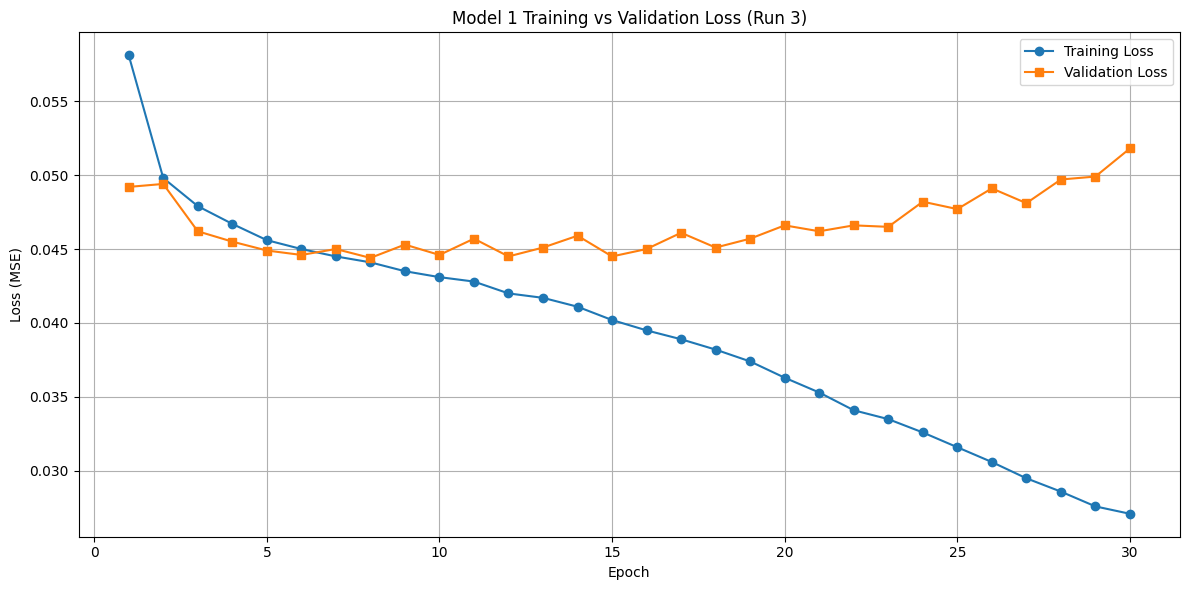

In [1]:
import matplotlib.pyplot as plt

# Recorded training and validation losses for 30 epochs
train_losses = [
    0.0581, 0.0498, 0.0479, 0.0467, 0.0456, 0.0450, 0.0445, 0.0441, 0.0435, 0.0431,
    0.0428, 0.0420, 0.0417, 0.0411, 0.0402, 0.0395, 0.0389, 0.0382, 0.0374, 0.0363,
    0.0353, 0.0341, 0.0335, 0.0326, 0.0316, 0.0306, 0.0295, 0.0286, 0.0276, 0.0271
]

val_losses = [
    0.0492, 0.0494, 0.0462, 0.0455, 0.0449, 0.0446, 0.0450, 0.0444, 0.0453, 0.0446,
    0.0457, 0.0445, 0.0451, 0.0459, 0.0445, 0.0450, 0.0461, 0.0451, 0.0457, 0.0466,
    0.0462, 0.0466, 0.0465, 0.0482, 0.0477, 0.0491, 0.0481, 0.0497, 0.0499, 0.0518
]

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, marker='o', label='Training Loss')
plt.plot(epochs, val_losses, marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Model 1 Training vs Validation Loss (Run 3)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = CNNModel1()  # Replace with your actual model class
print(f"Total Trainable Parameters: {count_parameters(model):,}")


Total Trainable Parameters: 252,691
